In [1]:
# PYTHON LIBRARIES
%matplotlib inline

import numpy as np;
import pandas as pd;
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=15)     
plt.rc('ytick', labelsize=15)

from scipy import special, optimize

########################################
def get_csv(filename):
    df = pd.read_csv(filename, delimiter=","); # Get CSV data
    units = df.iloc[0]; # Get units
    df = df.drop([0]); # Remove units row from dataframe
    
    #      [0]    [1]
    return units, df

### The Bird-Carreau-Yasuda Model [1]
### $$ \frac{\eta - \eta_{\infty}}{\eta_0 - \eta_{\infty}} = \frac{1}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} $$
### $$ \eta = \frac{\eta_0 - \eta_{\infty}}{\left[1 + \left(\kappa \dot{\gamma}\right)^a\right]^{\frac{(1 - n)}{a}}} + \eta_{\infty} $$

### where:
$\eta =$ Viscosity <br>
$\dot{\gamma} =$ Shear rate <br>
$\eta_{\infty} =$ Infinite shear rate viscosity <br>
$\eta_0 =$ Zero shear rate viscosity <br>
$\kappa =$ Time constant <br>
$n =$ The Power Law index <br>
$a =$ The width of the transition region between the zero shear viscosity and the Power Law region

#### [1] Osswald, T., Rudolph, N., Osswald, T., & Rudolph, N. (2014). Generalized Newtonian Fluid (GNF) Models. Polymer Rheology, 59–99. https://doi.org/10.3139/9781569905234.003

In [2]:
def GNF_(gamma, eta_inft, eta_zero, kappa, n, a): # The Bird-Carreau-Yasuda Model Bird
    nume = eta_zero - eta_inft;
    
    base = 1 + (kappa*gamma)**a
    expo = (1 - n)/a
    deno = base**expo;
    
    return (nume/deno) + eta_inft

C:\Users\oskat\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

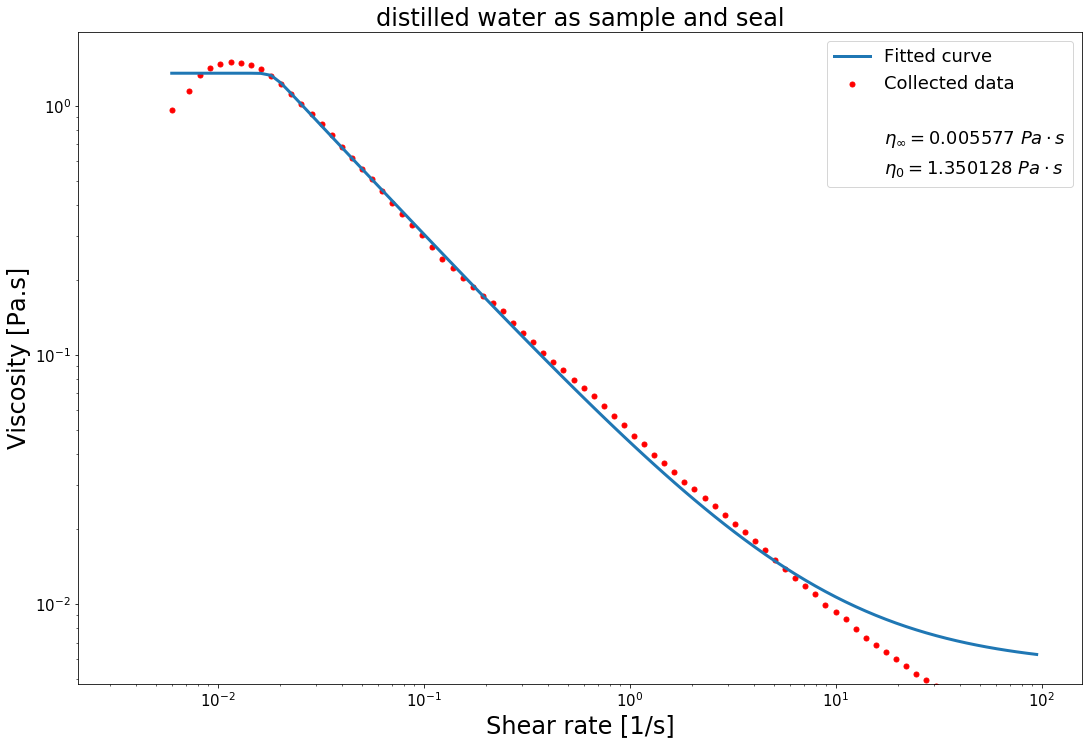

In [3]:
# Get units
units_df = get_csv("./csv/oskt_h2owseal.csv")[0]

# Get CSV data
nSeal_df = get_csv("./csv/oskt_h2owseal.csv")[1]
wSeal_df = get_csv("./csv/oskt_h2owseal.csv")[1]

# reasonable initial guesses for EOS parameters
eta_inft = 0
eta_zero = 1
kappa    = 0
n        = 0
a        = 1

# # PRINT table with fittig parameters
# tmplt_str_l = "  ".join(["{:<15}"] + ["{:<15}"]*5);
# tmplt_str_s = "  ".join(["{:<15}"] + ["{:<15.7}"]*5);
# print('')
# print('Fitting:')
# print(tmplt_str_l.format(*['parameters:', 'eta_inft', 'eta_zero', 'kappa', 'n', 'a']));
# print("-" * 96);

# Chose what to plot
x_index = 1; # gamma = Shear rate
y_index = 2; # eta   = Viscosity

# Optimization process
gamma = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float);
eta   = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float);
#eta_prev = GNF_(gamma, eta_inft, eta_zero, kappa, n, a);

p0 = eta_inft, eta_zero, kappa, n, a;
results = optimize.curve_fit(GNF_, gamma, eta, p0)

eta_inft = results[0][0];
eta_zero = results[0][1];
kappa    = results[0][2];
n        = results[0][3];
a        = results[0][4];
eta_fit = GNF_(gamma, eta_inft, eta_zero, kappa, n, a)

# # PRINT table with fittig parameters
# print(tmplt_str_s.format('Fit curve', *results[0], 0));

# Draw plot canvas
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));

# Plot
plt.scatter(gamma, eta, s=25, color='red', label='Collected data');
plt.plot(gamma, eta_fit, '-', linewidth=3, label='Fitted curve');

# Print fitting parameters as plot legends
x = gamma[0]
y = eta[0]
plt.scatter(x, y, s=0, label=' ')
plt.scatter(x, y, s=0, label=r'$\eta_{\infty} = $' + str(round(eta_inft, 6)) + r' $Pa \cdot s$')
plt.scatter(x, y, s=0, label=r'$\eta_0 = $' + str(round(eta_zero, 6)) + r' $Pa \cdot s$')
#plt.scatter(x, y, s=0, label=r'$\kappa = $' + str(round(kappa, 6)))
#plt.scatter(x, y, s=0, label=r'$n = $' + str(round(n, 6)))
#plt.scatter(x, y, s=0, label=r'$a = $' + str(round(a, 6)))

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel(str(nSeal_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
plt.ylabel(str(nSeal_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
plt.title('distilled water as sample and seal', size=24);
plt.legend(prop={'size': 18});
display(plt);

Stress                         MPa
Shear rate                     1/s
Viscosity                     Pa.s
Step time                        s
Temperature                     °C
Normal stress                  MPa
Axial force                      N
Gap                             µm
Normal stress coefficient    Pa.s²
Time                             s
Torque                        µN.m
Velocity                     rad/s
Name: 0, dtype: object

<module 'matplotlib.pyplot' from 'C:\\Users\\oskat\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

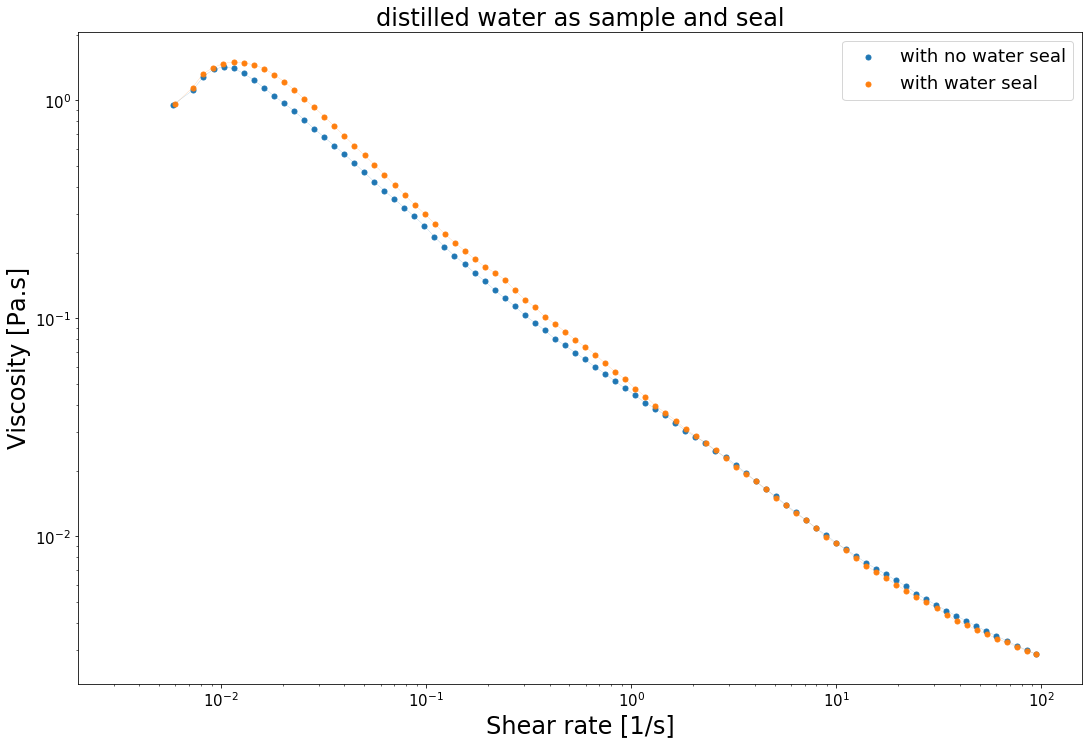

In [4]:
# Get units
units_df = get_csv("./oskt_h2onseal.csv")[0]
display(units_df)

# Get CSV data
nSeal_df = get_csv("./oskt_h2onseal.csv")[1]
wSeal_df = get_csv("./oskt_h2owseal.csv")[1]

# Draw plot canvas
scale = 6;
plt.subplots(figsize=(3*scale, 2*scale));

# Chose what to plot
x_index = 1
y_index = 2

# Plot
x = nSeal_df.iloc[:, x_index].to_numpy().astype(np.float)
y = nSeal_df.iloc[:, y_index].to_numpy().astype(np.float)
plt.scatter(x, y, s=25, label='with no water seal');
plt.plot(x, y, linewidth=0.125);

x = wSeal_df.iloc[:, x_index].to_numpy().astype(np.float)
y = wSeal_df.iloc[:, y_index].to_numpy().astype(np.float)
plt.scatter(x, y, s=25, label='with water seal');
plt.plot(x, y, linewidth=0.125);

# Display plots
plt.yscale('log');
plt.xscale('log');
plt.xlabel(str(nSeal_df.columns[x_index]) + " [" + str(units_df[x_index]) + "]", fontsize=24);
plt.ylabel(str(nSeal_df.columns[y_index]) + " [" + str(units_df[y_index]) + "]", fontsize=24);
plt.title('distilled water as sample and seal', size=24);
plt.legend(prop={'size': 18});
display(plt);